# Showcase for the Timothy Indicator Project

This notebook is writtet as an instruction on how to build model with Timothy Indicator and model explanation part. Data generation is not included.


In [54]:
## loading packages
import pandas as pd
import numpy as np
import talib as ta
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

## model exp
import lime
import lime.lime_tabular
import shap

In [55]:
## define our functions to calculate information and sharpe
def information_coefficient(y_true, y_pred):
    rho, pval = spearmanr(y_true,y_pred) #spearman's rank correlation
    # print (rho)
    return rho

def sharpe(y_true, y_pred):
    positions = np.where(y_pred> 0,1,-1 )
    dailyRet = pd.Series(positions).shift(1).fillna(0).values * y_true
    dailyRet = np.nan_to_num(dailyRet)
    ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
    return ratio

## Setup

In [56]:
## loading the full dataset, the creation is in other scripts
df = pd.read_csv('../data/DJI_full.csv')
df['Date'] = pd.to_datetime(df['Date'], format = '%Y%m%d')
df = df.set_index('Date')

In [57]:
## print last 5 rows because there will be a lot of nans in first few rows
df.tail(5)

,Open,High,Low,Close,Volume,RSI_20,RSI_25,DT_RSI_2_20,STO_20_1,MADIFF_10_100_0,...,MACD_10_100_5,LINTRND_10,PR_INT_0,PR_INT_20,CMMA_10_252,ENT_2_10,ENT_4_16,FTI_LP,FTI_BP,FTI_BF
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,36321.589844,36595.820312,36246.449219,36585.058594,347930000,59.75192,59.18160,4.78827,91.02052,30.63918,...,1.10693,20.53853,20.83455,9.56197,20.01494,-2.55565,2.80205,2217.11248,12.0,-37.58795
2022-01-04,36636.000000,36934.839844,36636.000000,36799.648438,435080000,58.54899,58.20707,-4.60246,90.19160,32.67949,...,0.88944,11.53766,-13.11281,3.04336,13.07427,-2.55565,2.80205,2223.21399,12.0,-36.82662
2022-01-05,36722.601562,36952.648438,36400.390625,36407.109375,462040000,51.42509,52.33847,-15.59942,78.51279,32.52100,...,-0.54035,0.10875,-26.37130,-9.36126,-13.43075,-2.55565,3.74974,2212.69053,13.0,-43.86609
2022-01-06,36409.050781,36464.191406,36200.679688,36236.468750,385890000,50.65286,51.69226,-16.09990,69.40255,32.05234,...,-1.36828,-1.62538,1.09288,-8.02846,-16.96815,-2.55565,4.63333,2194.51755,10.0,-43.15006
2022-01-07,36249.589844,36382.839844,36111.531250,36231.660156,356110000,49.68681,50.88723,-17.89526,61.70004,31.13385,...,-1.92560,-11.60251,-11.36312,-12.03224,-19.59055,-2.55565,8.15683,2176.41970,10.0,-40.06183


In [58]:
## calculate 30 days percentage returns
for n in list(range(1,30)):
    name = 'ret' + str(n)
    df[name] = df['Open'].pct_change(periods=n)#for trading with open

df['retFut1'] = df['Open'].pct_change(1).shift(-1).fillna(0)
## add two talib columns
df['RSI_20_ta'] = ta.RSI(np.array(df['Open']), timeperiod = 20)
df['RSI_25_ta'] = ta.RSI(np.array(df['Open']), timeperiod = 25)

In [59]:
## all our columns
indicator_col = [
       'RSI_20','RSI_20_ta', 'RSI_25','RSI_25_ta',
       'DT_RSI_2_20', 'STO_20_1', 'MADIFF_10_100_0', 'MADIFF_10_100',
       'MACD_10_100_5', 'LINTRND_10', 'PR_INT_0', 'PR_INT_20', 'CMMA_10_252',
       'ENT_2_10', 'ENT_4_16', 'FTI_LP', 'FTI_BP', 'FTI_BF'
]
base_col = ['ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6', 'ret7', 'ret8', 'ret9',
       'ret10', 'ret11', 'ret12', 'ret13', 'ret14', 'ret15', 'ret16', 'ret17',
       'ret18', 'ret19', 'ret20', 'ret21', 'ret22', 'ret23', 'ret24', 'ret25',
       'ret26', 'ret27', 'ret28', 'ret29']

## Modelling

In [60]:
## define time splits
split = TimeSeriesSplit(n_splits=5)
## use our customized functions for scorer
sharpe_scorer = make_scorer(sharpe, greater_is_better=True)
spearmanr_scorer = make_scorer(information_coefficient, greater_is_better=True)
scoring = {"rmse": "neg_root_mean_squared_error", 'sharpe': sharpe_scorer, 'spearmanr': spearmanr_scorer}

In [61]:
## this function use grid search with cross validation to fit the model
def tuning_model(X_train, y_train, pipeline, param_grid):
    grid_search = GridSearchCV(pipeline, param_grid, cv=split, scoring=scoring, refit='sharpe', return_train_score=True)
    grid_search.fit(X_train, y_train.values.ravel())
    best_parameters = grid_search.best_params_
    best_model = grid_search.best_estimator_
    results = pd.DataFrame(grid_search.cv_results_)
    return(grid_search, results, grid_search.best_score_*100)


In [62]:
## define a small parameter space for shwocase
numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 0)),
    ('scaler', StandardScaler())])
ridge = Ridge(max_iter=5000) 
a_rs = np.logspace(-40, 0, num=10, endpoint = True)

ridge_pipe = Pipeline(steps=[('preprocessor', numeric_sub_pipeline),('ridge', ridge)])
ridge_param_grid = [{ 'ridge__alpha': a_rs }]


In [63]:
indicator = 'CMMA_10_252'

# # create the data for modelling and tuning
df_model = df[base_col + ['retFut1',indicator]]
X_train = df_model.drop(['retFut1'], axis=1)
y_train = df_model[['retFut1']]

grid_search, res, eva = tuning_model(X_train, y_train, ridge_pipe, ridge_param_grid)

In [64]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value=0,
                                                strategy='constant')),
                                 ('scaler', StandardScaler())])),
                ('ridge', Ridge(alpha=1e-40, max_iter=5000))])

## Lime

Lime is Local Surrogate model. It only looks on one observation and predict the feature values for this.

Please refer to [Github Link](https://github.com/marcotcr/lime)

In [65]:
## create explainer def
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['retFut1'], verbose=True, mode='regression', discretize_continuous=False)
## Run the explainer for the observation 600 in X_train using the grid_search and only get top 6 features
exp = explainer.explain_instance(X_train.values[600], grid_search.predict, num_features=6, )
exp.show_in_notebook(show_table=True, show_all=False)

X does not have valid feature names, but SimpleImputer was fitted with feature names


Intercept 0.0005004970162683405
Prediction_local [0.00606721]
Right: 0.004828969316748355


## Shap Value

Shapley Values

More details, please refer here [Official Doc](https://shap.readthedocs.io/en/latest/)

In [66]:
def shap_wrapper(model, X_train, plot_title):
    ## create Shap explainer using model and X
    explainer = shap.Explainer(model.predict, X_train)
    model_exp = explainer(X_train)
    ## plot
    plt.clf()
    shap.summary_plot(model_exp, features=X_train, feature_names=X_train.columns, show=False)
    plt.title(plot_title)

def shap_plot(model, X_train, model_name,indicator_name, ticker_name, outdir = None):
    
    plot_title = f'{model_name}_{indicator_name}_indicator'

    shap_wrapper(model, X_train, plot_title)
    
    ## save the plot is outdir is given
    if(outdir):
        plot_location = f'{outdir}/{ticker_name}_{plot_title}_shap.png'
        plt.savefig(plot_location)

Permutation explainer: 3022it [02:44, 18.34it/s]                          


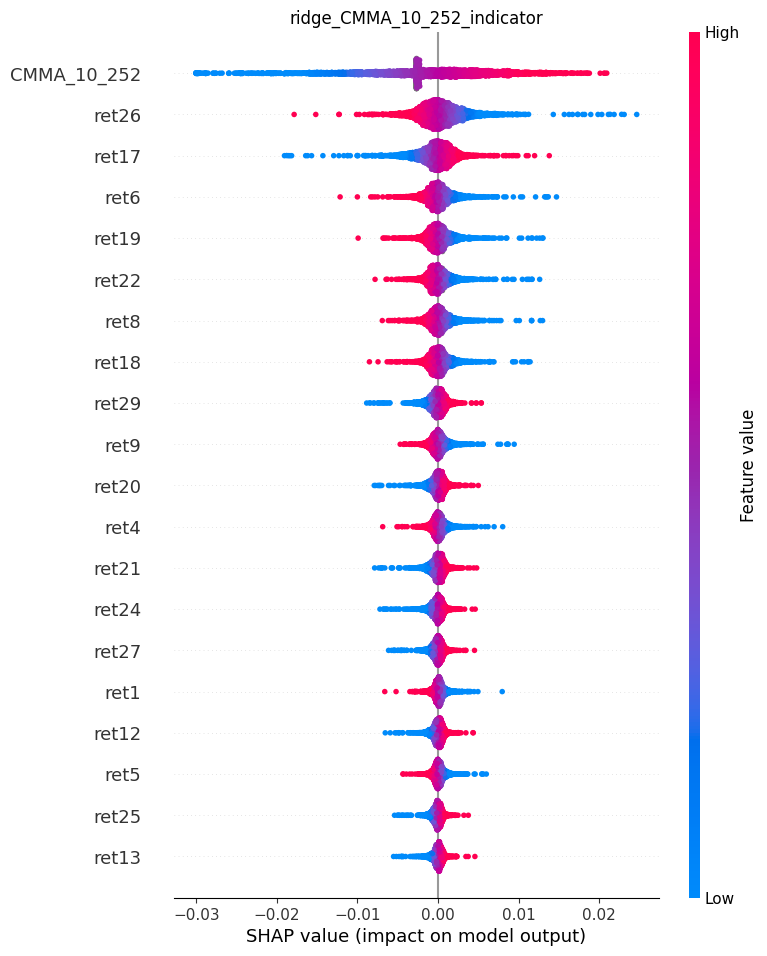

In [67]:
shap_plot(grid_search, X_train, model_name='ridge', indicator_name=indicator, ticker_name='dji')

In [68]:
# shap_plot(grid_search, X_train, model_name='ridge', indicator_name=indicator, ticker_name='dji', outdir='.')